# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import celerite2
from celerite2 import terms
import torch
from numpy.linalg import solve

# Import raw data

In [2]:
#File containing temperature values
raw_T_data = np.loadtxt('/Users/samsonmercier/Desktop/Work/PhD/Research/Second_Generals/Data/bt-4500k/training_data_T.csv', delimiter=',')
#File containing pressure values
raw_P_data = np.loadtxt('/Users/samsonmercier/Desktop/Work/PhD/Research/Second_Generals/Data/bt-4500k/training_data_P.csv', delimiter=',')

#Last 51 columns are the temperature/pressure values, 
#First 5 are the input values (H2 pressure in bar, CO2 pressure in bar, LoD in hours, Obliquity in deg, H2+Co2 pressure) but we remove the last one since it's not adding info.
raw_inputs = raw_T_data[:, :4]
raw_outputs_T = raw_T_data[:, 5:]
raw_outputs_P = raw_P_data[:, 5:]

#Storing useful quantitites
N = raw_inputs.shape[0] #Number of data points
D = raw_inputs.shape[1] #Number of features
O = raw_outputs_T.shape[1] #Number of outputs

# Plotting of the T-P profiles

In [ ]:
for raw_input, raw_output_T, raw_output_P in zip(raw_inputs,raw_outputs_T,raw_outputs_P):
    fig, ax = plt.subplots(1, 1, figsize=[8, 6])
    ax.plot(raw_output_T, np.log(raw_output_P/1000), color='blue', linewidth=2)
    ax.invert_yaxis()
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel(r'log$_{10}$ Pressure (bar)')
    ax.set_title(rf'H$_2$O : {raw_input[0]} bar, CO$_2$ : {raw_input[1]} bar, LoD : {raw_input[2]:.0f} days, Obliquity : {raw_input[3]} deg')
    plt.show()

# Fitting data with a Gaussian Process (celerite) - trying it out on one T-P profile (Can't be generalized)

In [ ]:
key = 4

#Plot the T-P profile we want to look at
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=[8, 6], gridspec_kw={'height_ratios':[3,1]})
ax1.plot(np.log(raw_outputs_P[4]/1000), raw_outputs_T[4], '.', color='blue', linewidth=2, label='Data')
ax1.invert_yaxis()
ax1.set_ylabel('Temperature (K)')
ax2.set_ylabel('Residuals')
ax2.set_xlabel(r'log$_{10}$ Pressure (bar)')
ax1.set_title(rf'H$_2$O : {raw_inputs[key][0]} bar, CO$_2$ : {raw_inputs[key][1]} bar, LoD : {raw_inputs[key][2]:.0f} days, Obliquity : {raw_inputs[key][3]} deg')

#GP
#Defining a quasi-periodic term
term1 = terms.SHOTerm(sigma=1.0, rho=1.0, tau=10.0)

#Defining a non-periodic term
term2 = terms.SHOTerm(sigma=1.0, rho=5.0, Q=0.25)
kernel = term1 + term2

# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(np.log(raw_outputs_P[4]/1000))

#Plot resulting GP fit
pred_T, variance = gp.predict(raw_outputs_T[4], t=np.log(raw_outputs_P[4]/1000), return_var=True)
sigma = np.sqrt(variance)
ax1.plot(np.log(raw_outputs_P[4]/1000), pred_T, label='initial guess')
ax1.fill_between(np.log(raw_outputs_P[4]/1000), pred_T - sigma, pred_T + sigma, color="C0", alpha=0.2)
ax2.plot(np.log(raw_outputs_P[4]/1000), raw_outputs_T[4]-pred_T)
ax2.axhline(0, color='black', linestyle='--')
plt.legend()
plt.show()

# Fitting data with an Inverse Ensemble GP

## First step : partition data into a training set, and a testing set

In [3]:
#Defining partition of data used for 1. training and 2. testing
data_partition = [0.9999, 0.0001]

#Defining the noise seed for the random partitioning of the training data
partition_seed = 4

#Splitting the data 
## Setting noise seed
generator = torch.Generator().manual_seed(partition_seed)
## Retrieving indices of data partitions
train_idx, test_idx = torch.utils.data.random_split(range(N), data_partition, generator=generator)
## Generate the data partitions
### Training
train_inputs = raw_inputs[train_idx]
train_outputs_T = raw_outputs_T[train_idx]
### Testing
test_inputs = raw_inputs[test_idx]
test_outputs_T = raw_outputs_T[test_idx]

## Second step : Building Inverse Ensemble GP function (also known as an ensemble Kalman inversion)

In [4]:
def Inv_ens_GP(train_features, train_labels, obs_labels, regul_sigma):
    """
    Does ensemble Gaussian process
    Inputs: 
        train_features : ndarray (N, D)
            Features of the N training data points.
        train_labels : ndarray (N, K)
            Labels of the N training data points.
        obs_labels : ndarray (M, K)
            Labels of the observation(s) we want to find the features for.
        regul_sigma : float
            Regularizer value
    Outputs:
        obs_features : ndarray (M, D)
            Features of the observation(s).
        cov_obs_features : ndarray (D, D)
            Covariance matrix of the returned features.

    """
    # 1. Retrieve basic properties
    N, K = train_labels.shape
        
    # 3. Compute means and ensemble anomalies
    mean_train_features = np.mean(train_features, axis=0, keepdims=True)
    dM = (train_features - mean_train_features).T

    mean_train_labels = np.mean(train_labels, axis=0, keepdims=True)
    dD = (train_labels - mean_train_labels).T

    # 4. Covariance matrices
    C_xy = (dM @ dD.T) / (N - 1)
    C_yy = (dD @ dD.T) / (N - 1)

    # 5. Add ridge regularizer
    C_yy += np.diag(regul_sigma * np.ones(K))

    # 6. Innovation and Kalman update
    innovation = (obs_labels[0] - mean_train_labels).T
    obs_features = train_features.T + (C_xy @ solve(C_yy, innovation))
    obs_features = obs_features.T
    
    return obs_features

In [5]:
# Retrieve model features for all the testing data
model_test_inputs = Inv_ens_GP(train_inputs, train_outputs_T, test_outputs_T, 1e-9)

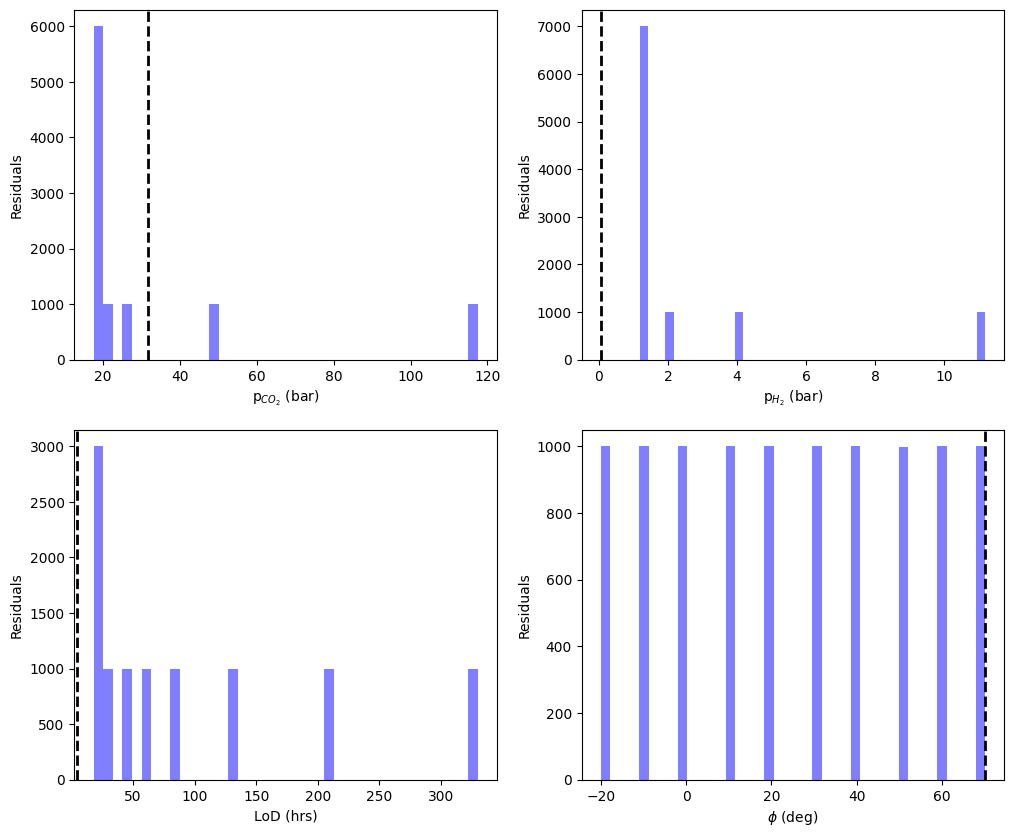

In [ ]:
# Basic diagnostic plot

## Showing the model features vs the real ones 

fig, axs = plt.subplots(2, 2, figsize=[12, 10])

for idx, (feature_plot_label, ax) in enumerate(zip([r'p$_{CO_2}$ (bar)',r'p$_{H_2}$ (bar)','LoD (hrs)',r'$\phi$ (deg)'],axs.ravel())):
    ax.hist(model_test_inputs[:,idx], bins=40, alpha=0.5, color='blue')
    ax.axvline(test_inputs[:, idx], color='black', linestyle='dashed', linewidth=2)
    ax.set_xlabel(feature_plot_label)
    ax.set_ylabel('Residuals')

plt.show()

## Third step : Explore the impact of partition size

In [ ]:
#Defining partition of data used for 1. training and 2. testing
data_partitions = [[0.5, 0.5], [0.7, 0.3], [0.9, 0.1], [0.99, 0.01]]

#Defining the noise seed for the random partitioning of the training data
partition_seed = 4

# Setting noise seed
generator = torch.Generator().manual_seed(partition_seed)

# Initialize figure
fig1, axs1 = plt.subplots(2, 2, figsize=[17, 10])
fig2, axs2 = plt.subplots(2, 2, figsize=[17, 10])
fig3, axs3 = plt.subplots(2, 2, figsize=[17, 10])

for part_idx, (data_partition, partition_color) in enumerate(zip(data_partitions, ['blue', 'green', 'red', 'black'])):
    
    #Splitting the data 
    ## Retrieving indices of data partitions
    train_idx, test_idx = torch.utils.data.random_split(range(N), data_partition, generator=generator)
    ## Generate the data partitions
    ### Training
    train_inputs = raw_inputs[train_idx]
    train_outputs_T = raw_outputs_T[train_idx]
    ### Testing
    test_inputs = raw_inputs[test_idx]
    test_outputs_T = raw_outputs_T[test_idx]

    # Retrieve model features for all the testing data
    model_test_inputs, model_test_inputs_cov = Inv_ens_GP(train_inputs, train_outputs_T, test_outputs_T, 1e-9)

    # Retrieve errors on the model features
    model_test_inputs_err = np.sqrt(np.diag(model_test_inputs_cov))

    # Basic diagnostic plot
    ## Showing the model features vs the real ones 
    for idx, (feature_plot_label, ax) in enumerate(zip([r'p$_{CO_2}$ (bar)',r'p$_{H_2}$ (bar)','LoD (hrs)',r'$\phi$ (deg)'],axs1.ravel())):
        # Compute feature "step" appropriately
        if idx in [0, 1, 2]:  # these have log x-scale
            ax.set_xscale('log')
            log_x = np.log10(test_inputs[:, idx])
            log_step = np.diff(np.unique(log_x)).mean()
            # multiplicative offset factor in linear space
            offset_factor = 10 ** (part_idx * log_step / 5)
            x_offset = test_inputs[:, idx] * offset_factor
        else:
            feature_step_size = np.diff(np.unique(test_inputs[:, idx])).mean()
            x_offset = test_inputs[:, idx] + (part_idx * feature_step_size / 5)
            
        feature_step_size = np.diff(np.unique(test_inputs[:, idx]))[0]
        ax.errorbar(x_offset, test_inputs[:, idx] - model_test_inputs[:, idx], yerr = model_test_inputs_err[idx], fmt='.', color=partition_color)
        ax.set_xlabel(feature_plot_label)
        ax.set_ylabel('Residuals')

    ## Showing the model features vs the real ones (% difference)

    for idx, (feature_plot_label, ax) in enumerate(zip([r'p$_{CO_2}$ (bar)',r'p$_{H_2}$ (bar)','LoD (hrs)',r'$\phi$ (deg)'],axs2.ravel())):
        # Compute feature "step" appropriately
        if idx in [0, 1, 2]:  # these have log x-scale
            ax.set_xscale('log')
            log_x = np.log10(test_inputs[:, idx])
            log_step = np.diff(np.unique(log_x)).mean()
            # multiplicative offset factor in linear space
            offset_factor = 10 ** (part_idx * log_step / 5)
            x_offset = test_inputs[:, idx] * offset_factor
        else:
            feature_step_size = np.diff(np.unique(test_inputs[:, idx])).mean()
            x_offset = test_inputs[:, idx] + (part_idx * feature_step_size / 5)
            
        feature_step_size = np.diff(np.unique(test_inputs[:, idx]))[0]
        percent_rel_diff = 100*(np.abs(test_inputs[:, idx] - model_test_inputs[:, idx]))/test_inputs[:, idx]
        ax.plot(x_offset, percent_rel_diff, '.', color=partition_color, label=f'Med : {np.median(percent_rel_diff):.2f}')
        ax.set_xlabel(feature_plot_label)
        ax.set_ylabel('Residuals (% difference)')
        ax.axhline(np.median(percent_rel_diff), color=partition_color)
        ax.legend()

    ## Showing the model features vs the real ones (sigma difference)

    for idx, (feature_plot_label, ax) in enumerate(zip([r'p$_{CO_2}$ (bar)',r'p$_{H_2}$ (bar)','LoD (hrs)',r'$\phi$ (deg)'],axs3.ravel())):
        # Compute feature "step" appropriately
        if idx in [0, 1, 2]:  # these have log x-scale
            ax.set_xscale('log')
            log_x = np.log10(test_inputs[:, idx])
            log_step = np.diff(np.unique(log_x)).mean()
            # multiplicative offset factor in linear space
            offset_factor = 10 ** (part_idx * log_step / 5)
            x_offset = test_inputs[:, idx] * offset_factor
        else:
            feature_step_size = np.diff(np.unique(test_inputs[:, idx])).mean()
            x_offset = test_inputs[:, idx] + (part_idx * feature_step_size / 5)
            
        feature_step_size = np.diff(np.unique(test_inputs[:, idx]))[0]
        sigma_diff = np.abs(test_inputs[:, idx] - model_test_inputs[:, idx])/ model_test_inputs_err[idx]
        ax.plot(x_offset, sigma_diff, '.', color=partition_color, label=f'Med : {np.median(sigma_diff):.2f}')
        ax.set_xlabel(feature_plot_label)
        ax.set_ylabel(r'Residuals ($\sigma$ difference)')
        ax.axhline(np.median(sigma_diff), color=partition_color)
        ax.legend()



## Fourth step : Explore the impact of regularizer

In [ ]:
#Defining partition of data used for 1. training and 2. testing
data_partition = [0.9, 0.1]

#Defining the noise seed for the random partitioning of the training data
partition_seed = 4

# Setting noise seed
generator = torch.Generator().manual_seed(partition_seed)

# Defining regularizer coefficient
lambda_regs = [1, 1e-3, 1e-6, 1e-9, 1e-12]

# Initialize figure
fig1, axs1 = plt.subplots(2, 2, figsize=[17, 10])
fig2, axs2 = plt.subplots(2, 2, figsize=[17, 10])
fig3, axs3 = plt.subplots(2, 2, figsize=[17, 10])

for part_idx, (lambda_reg, partition_color) in enumerate(zip(lambda_regs, ['blue', 'green', 'red', 'black', 'yellow'])):
    
    #Splitting the data 
    ## Retrieving indices of data partitions
    train_idx, test_idx = torch.utils.data.random_split(range(N), data_partition, generator=generator)
    ## Generate the data partitions
    ### Training
    train_inputs = raw_inputs[train_idx]
    train_outputs_T = raw_outputs_T[train_idx]
    ### Testing
    test_inputs = raw_inputs[test_idx]
    test_outputs_T = raw_outputs_T[test_idx]

    # Retrieve model features for all the testing data
    model_test_inputs, model_test_inputs_cov = Inv_ens_GP(train_inputs, train_outputs_T, test_outputs_T, lambda_reg)

    # Retrieve errors on the model features
    model_test_inputs_err = np.sqrt(np.diag(model_test_inputs_cov))

    # Basic diagnostic plot
    ## Showing the model features vs the real ones 
    for idx, (feature_plot_label, ax) in enumerate(zip([r'p$_{CO_2}$ (bar)',r'p$_{H_2}$ (bar)','LoD (hrs)',r'$\phi$ (deg)'],axs1.ravel())):
        # Compute feature "step" appropriately
        if idx in [0, 1, 2]:  # these have log x-scale
            ax.set_xscale('log')
            log_x = np.log10(test_inputs[:, idx])
            log_step = np.diff(np.unique(log_x)).mean()
            # multiplicative offset factor in linear space
            offset_factor = 10 ** (part_idx * log_step / 6)
            x_offset = test_inputs[:, idx] * offset_factor
        else:
            feature_step_size = np.diff(np.unique(test_inputs[:, idx])).mean()
            x_offset = test_inputs[:, idx] + (part_idx * feature_step_size / 6)
            
        feature_step_size = np.diff(np.unique(test_inputs[:, idx]))[0]
        ax.errorbar(x_offset, test_inputs[:, idx] - model_test_inputs[:, idx], yerr = model_test_inputs_err[idx], fmt='.', color=partition_color)
        ax.set_xlabel(feature_plot_label)
        ax.set_ylabel('Residuals')

    ## Showing the model features vs the real ones (% difference)

    for idx, (feature_plot_label, ax) in enumerate(zip([r'p$_{CO_2}$ (bar)',r'p$_{H_2}$ (bar)','LoD (hrs)',r'$\phi$ (deg)'],axs2.ravel())):
        # Compute feature "step" appropriately
        if idx in [0, 1, 2]:  # these have log x-scale
            ax.set_xscale('log')
            log_x = np.log10(test_inputs[:, idx])
            log_step = np.diff(np.unique(log_x)).mean()
            # multiplicative offset factor in linear space
            offset_factor = 10 ** (part_idx * log_step / 6)
            x_offset = test_inputs[:, idx] * offset_factor
        else:
            feature_step_size = np.diff(np.unique(test_inputs[:, idx])).mean()
            x_offset = test_inputs[:, idx] + (part_idx * feature_step_size / 6)
            
        feature_step_size = np.diff(np.unique(test_inputs[:, idx]))[0]
        percent_rel_diff = 100*(np.abs(test_inputs[:, idx] - model_test_inputs[:, idx]))/test_inputs[:, idx]
        ax.plot(x_offset, percent_rel_diff, '.', color=partition_color, label=f'Med : {np.median(percent_rel_diff):.2f}')
        ax.set_xlabel(feature_plot_label)
        ax.set_ylabel('Residuals (% difference)')
        ax.axhline(np.median(percent_rel_diff), color=partition_color)
        ax.legend()

    ## Showing the model features vs the real ones (sigma difference)

    for idx, (feature_plot_label, ax) in enumerate(zip([r'p$_{CO_2}$ (bar)',r'p$_{H_2}$ (bar)','LoD (hrs)',r'$\phi$ (deg)'],axs3.ravel())):
        # Compute feature "step" appropriately
        if idx in [0, 1, 2]:  # these have log x-scale
            ax.set_xscale('log')
            log_x = np.log10(test_inputs[:, idx])
            log_step = np.diff(np.unique(log_x)).mean()
            # multiplicative offset factor in linear space
            offset_factor = 10 ** (part_idx * log_step / 6)
            x_offset = test_inputs[:, idx] * offset_factor
        else:
            feature_step_size = np.diff(np.unique(test_inputs[:, idx])).mean()
            x_offset = test_inputs[:, idx] + (part_idx * feature_step_size / 6)
            
        feature_step_size = np.diff(np.unique(test_inputs[:, idx]))[0]
        sigma_diff = np.abs(test_inputs[:, idx] - model_test_inputs[:, idx])/ model_test_inputs_err[idx]
        ax.plot(x_offset, sigma_diff, '.', color=partition_color, label=f'Med : {np.median(sigma_diff):.2f}')
        ax.set_xlabel(feature_plot_label)
        ax.set_ylabel(r'Residuals ($\sigma$ difference)')
        ax.axhline(np.median(sigma_diff), color=partition_color)
        ax.legend()



# Fitting data with an Ensemble GP

## First step : partition data into a training set, and a testing set

In [3]:
#Defining partition of data used for 1. training and 2. testing
data_partition = [0.9999, 0.0001]

#Defining the noise seed for the random partitioning of the training data
partition_seed = 4

#Splitting the data 
## Setting noise seed
generator = torch.Generator().manual_seed(partition_seed)
## Retrieving indices of data partitions
train_idx, test_idx = torch.utils.data.random_split(range(N), data_partition, generator=generator)
## Generate the data partitions
### Training
train_inputs = raw_inputs[train_idx]
train_outputs_T = raw_outputs_T[train_idx]
train_outputs_P = raw_outputs_P[train_idx]

### Testing
test_inputs = raw_inputs[test_idx]
test_outputs_T = raw_outputs_T[test_idx]
test_outputs_P = raw_outputs_P[test_idx]

## Second step : Building Inverse Ensemble GP function (also known as an ensemble Kalman inversion)

In [4]:
def ens_GP(train_features, train_labels, obs_features, regul_sigma):
    """
    Does ensemble Gaussian process
    Inputs: 
        train_features : ndarray (N, D)
            Features of the N training data points.
        train_labels : ndarray (N, K)
            Labels of the N training data points.
        obs_features : ndarray (M, K)
            Features of the observation(s) we want to find the labels for.
        regul_sigma : float
            Regularizer value
    Outputs:
        obs_labels : ndarray (M, D)
            Labels of the observation(s).
        cov_obs_labels : ndarray (D, D)
            Covariance matrix of the returned labels.

    """
    # 1. Retrieve basic properties
    N, D = train_features.shape
        
    # 3. Compute ensemble means and ensemble anomalies
    mean_train_features = np.mean(train_features, axis=0, keepdims=True)
    mean_train_labels = np.mean(train_labels, axis=0, keepdims=True)
    
    # 4. Compute ensemble anomalies
    dF = (train_features - mean_train_features).T   #(D,N)
    dL = (train_labels - mean_train_labels).T       #(K,N)

    # 5. Covariance matrices
    C_lf = (dL @ dF.T) / (N - 1)
    C_ff = (dF @ dF.T) / (N - 1)

    # 6. Add ridge regularizer
    C_ff += np.diag(regul_sigma * np.ones(D))

    # 7. Innovation and Kalman update
    innovation = (obs_features[0] - train_features).T
    obs_labels = train_labels.T + (C_lf @ solve(C_ff, innovation))
    obs_labels = obs_labels.T
    
    return obs_labels

In [5]:
# Retrieve model features for all the testing data
model_test_outputs_T = ens_GP(train_inputs, train_outputs_T, test_inputs, 1e-9)

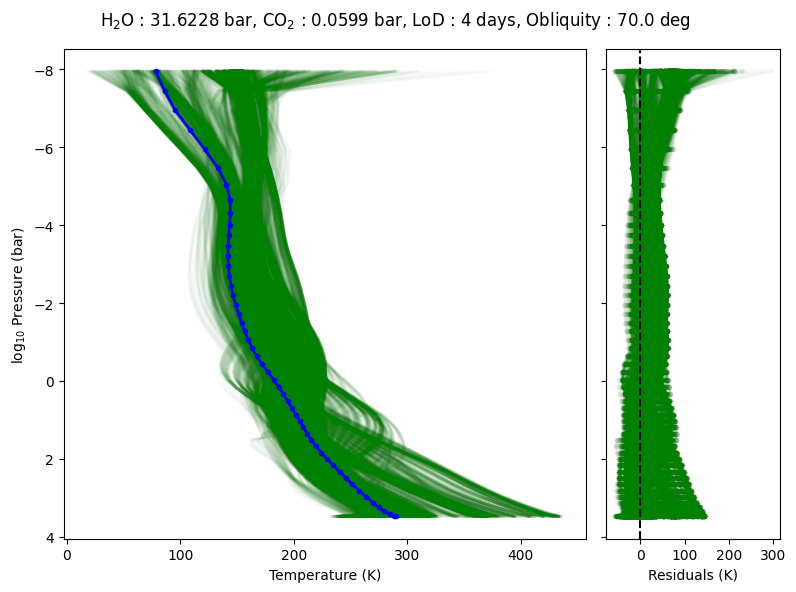

In [6]:
# Basic diagnostic plot

#Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8, 6], sharey=True, gridspec_kw = {'width_ratios':[3, 1]})
ax1.plot(test_outputs_T[0], np.log(test_outputs_P[0]/1000), '.', linestyle='-', color='blue', linewidth=2, zorder=2)
for pred_output_T in model_test_outputs_T:ax1.plot(pred_output_T, np.log(test_outputs_P[0]/1000), color='green', alpha=0.01, linewidth=2, zorder=1)
ax1.invert_yaxis()
ax1.set_ylabel(r'log$_{10}$ Pressure (bar)')
ax1.set_xlabel('Temperature (K)')
for pred_output_T in model_test_outputs_T:ax2.plot(pred_output_T - test_outputs_T[0], np.log(test_outputs_P[0]/1000), '.', linestyle='-', alpha=0.01, color='green', linewidth=2)
ax2.axvline(0, color='black', linestyle='dashed', zorder=2)
ax2.set_xlabel('Residuals (K)')
plt.suptitle(rf'H$_2$O : {test_inputs[0][0]} bar, CO$_2$ : {test_inputs[0][1]} bar, LoD : {test_inputs[0][2]:.0f} days, Obliquity : {test_inputs[0][3]} deg')
plt.tight_layout()
plt.show()

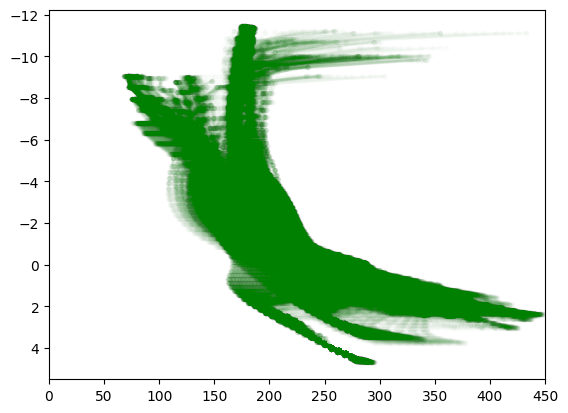

In [15]:
# Basic diagnostic plot

#Plotting
fig, ax=plt.subplots()
for train_output_T, train_output_P in zip(train_outputs_T, train_outputs_P):
    ax.plot(train_output_T, np.log(train_output_P/1000), '.', linestyle='-', color='green', linewidth=2, alpha=0.01)
ax.invert_yaxis()
ax.set_xlim(0, 450)
plt.show()

## Third step : Explore the impact of partition size

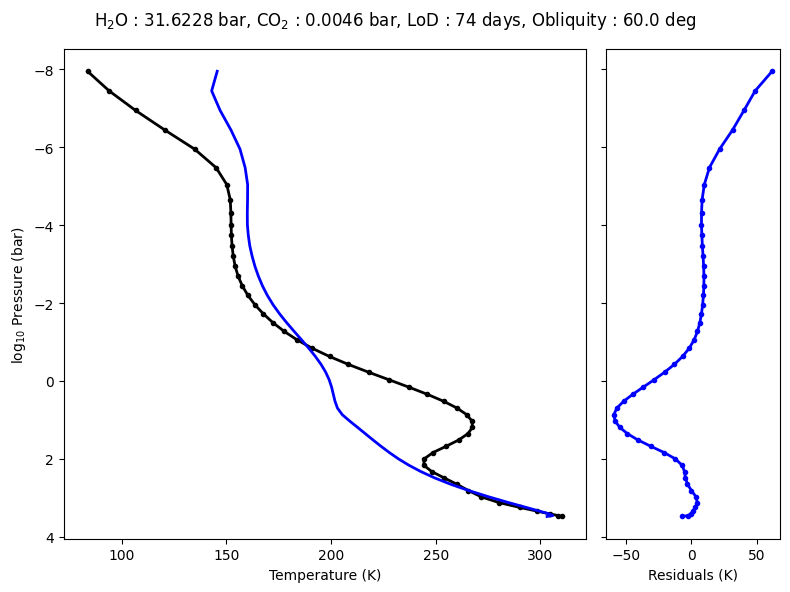

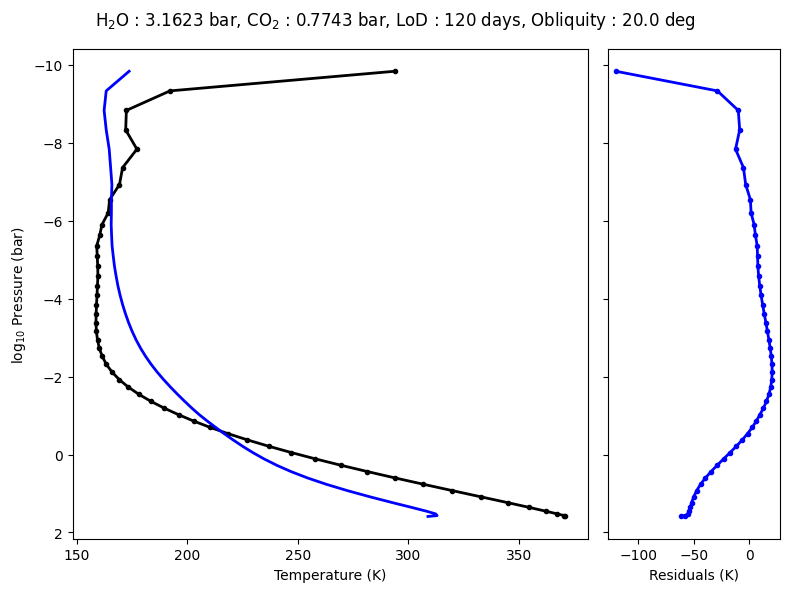

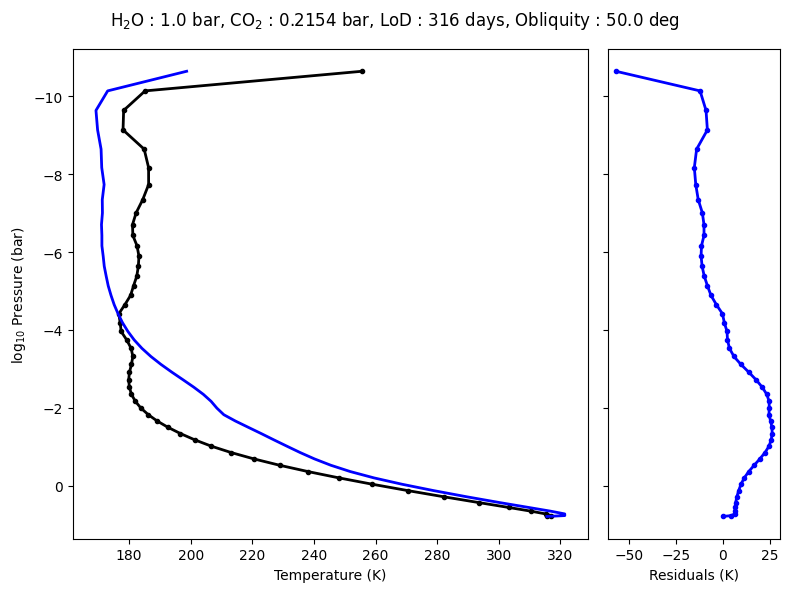

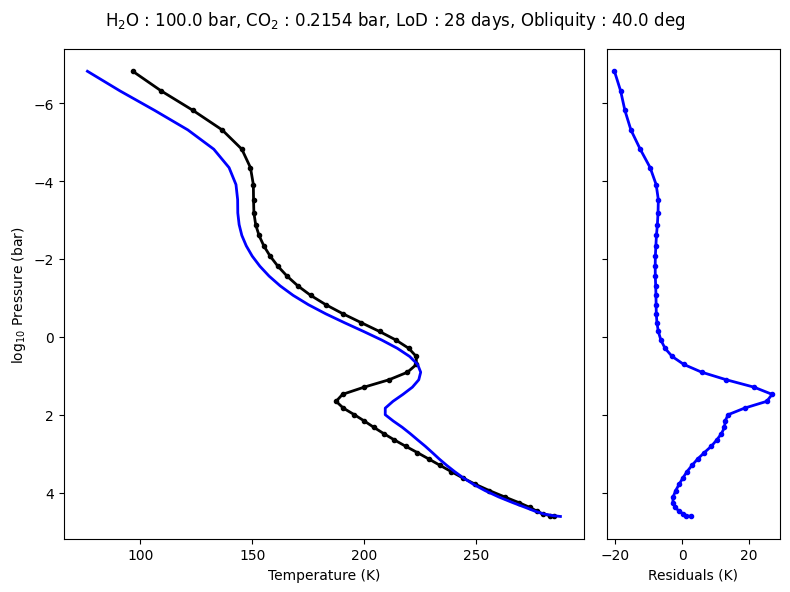

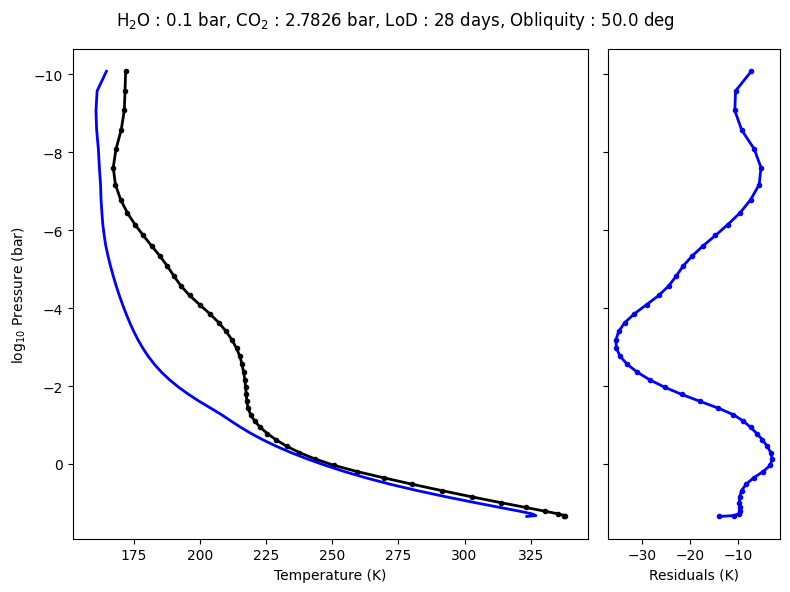

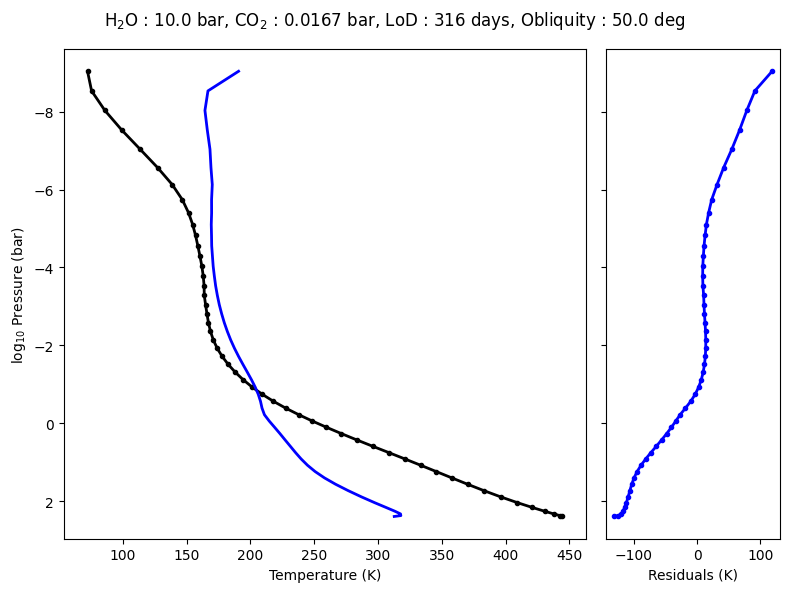

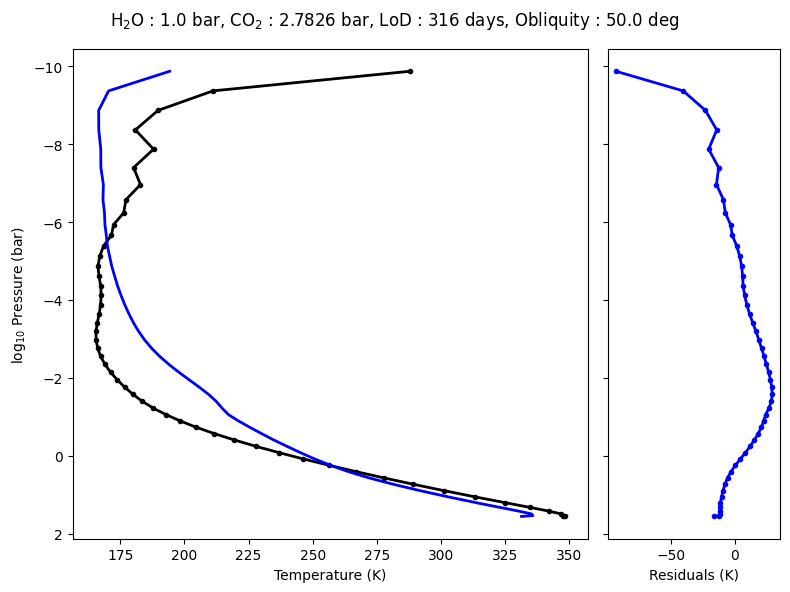

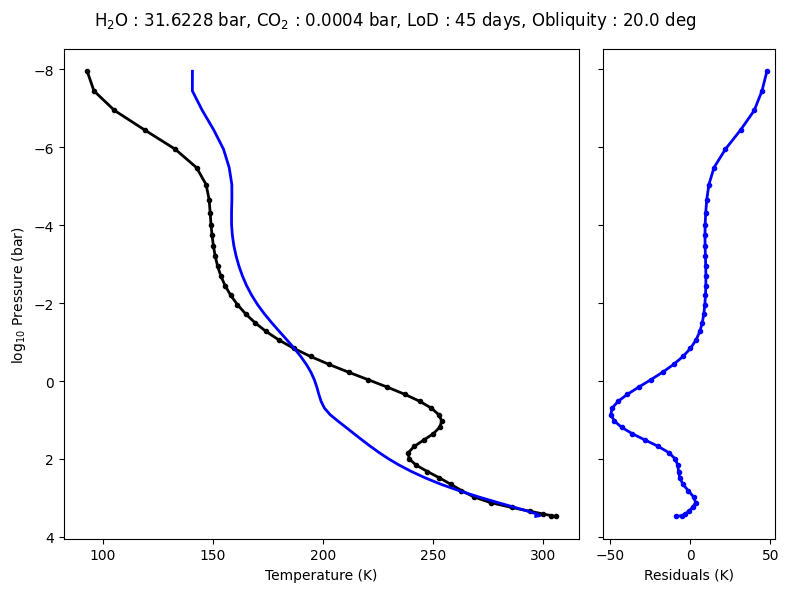

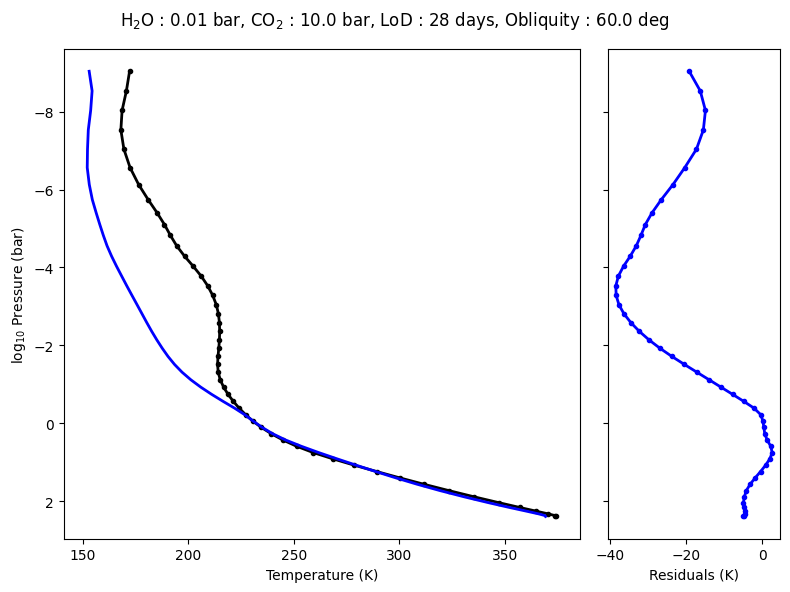

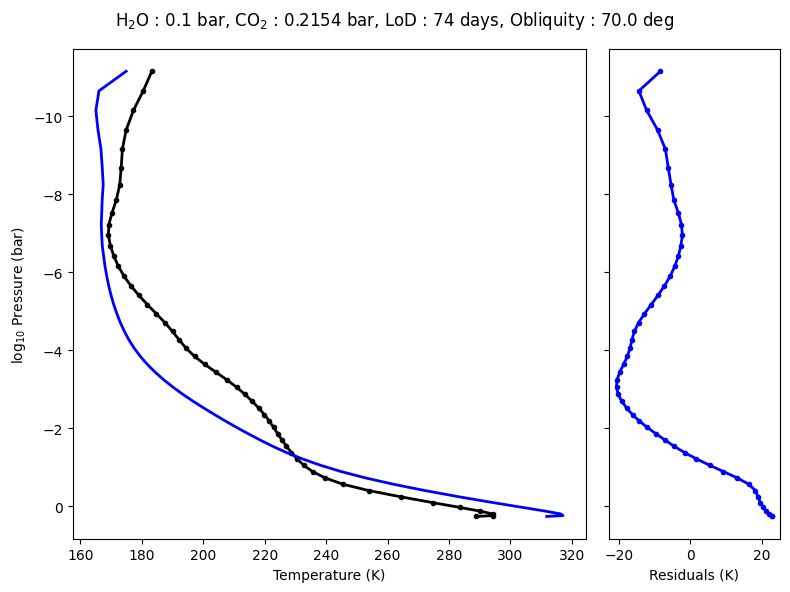

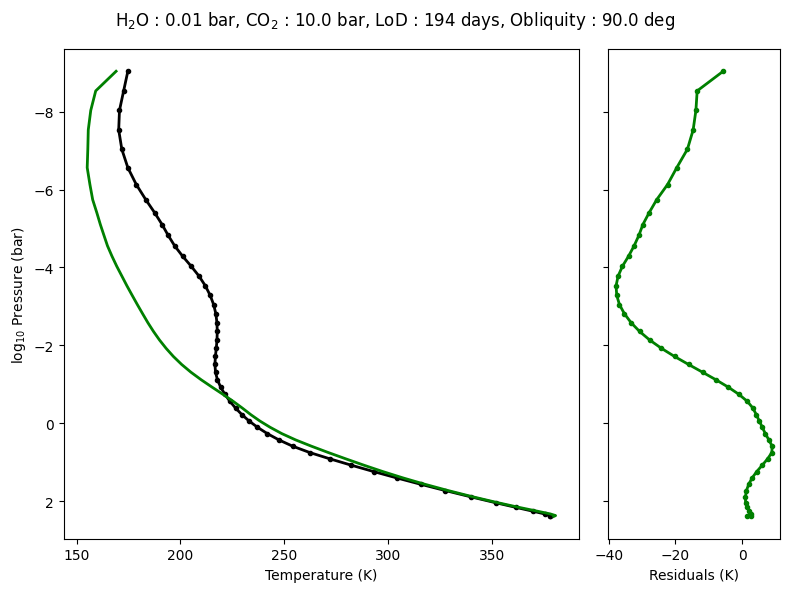

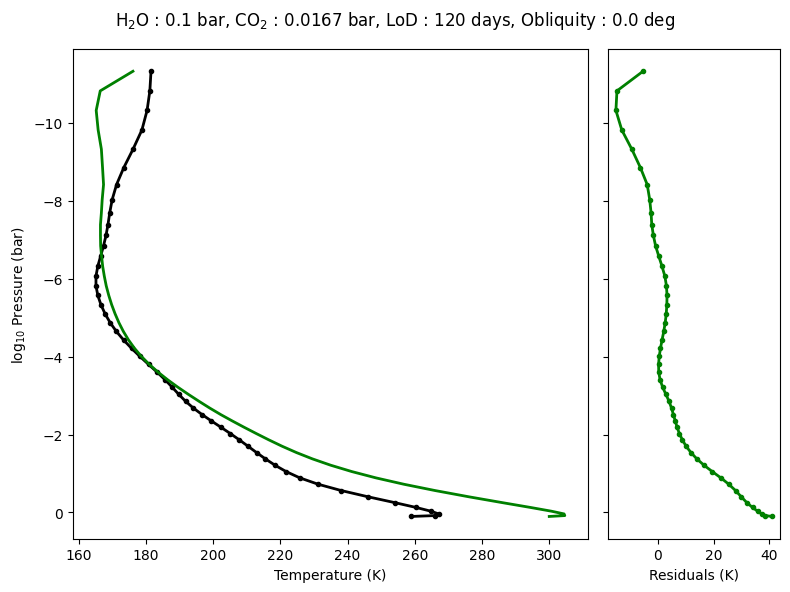

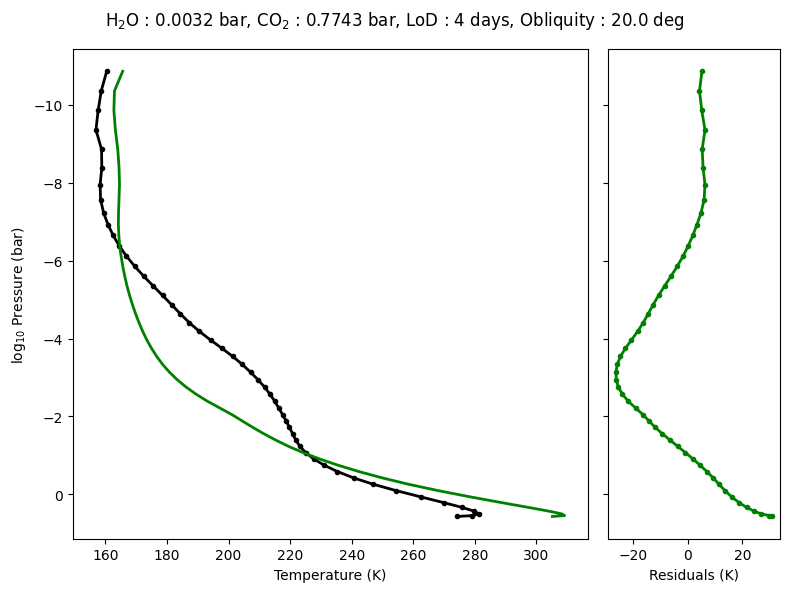

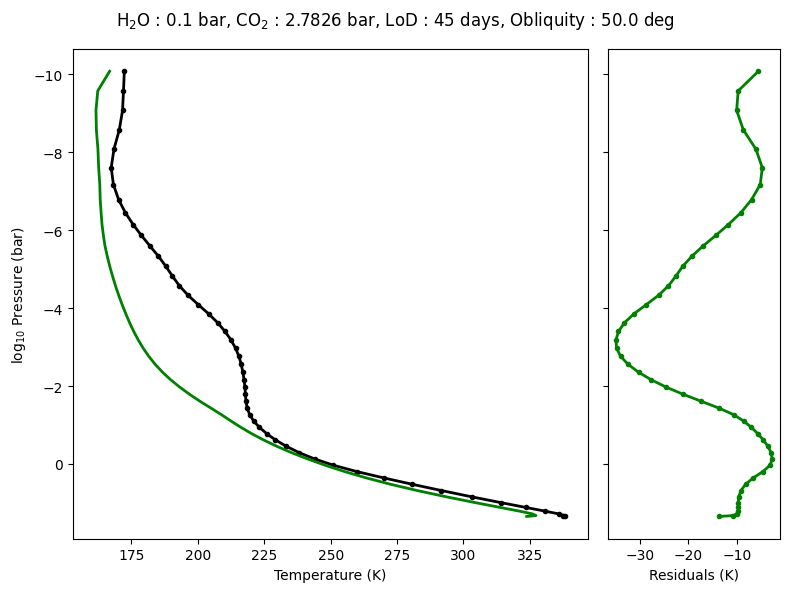

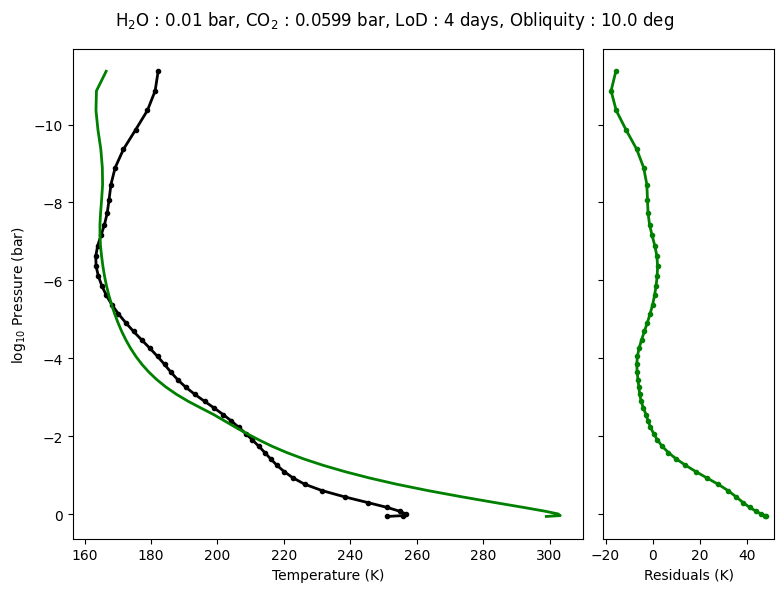

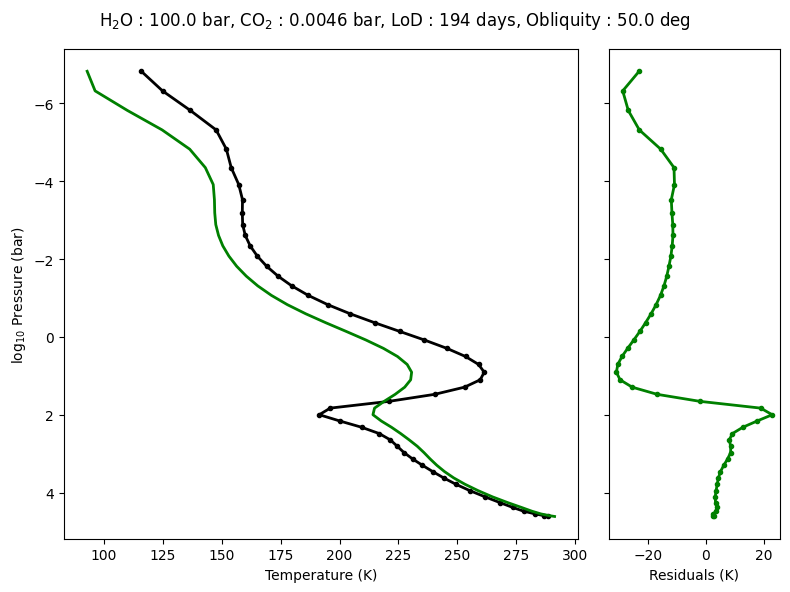

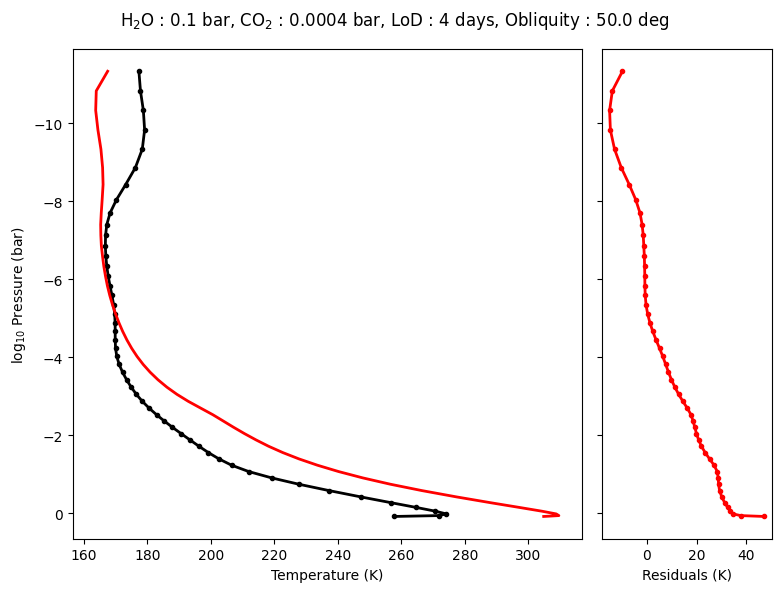

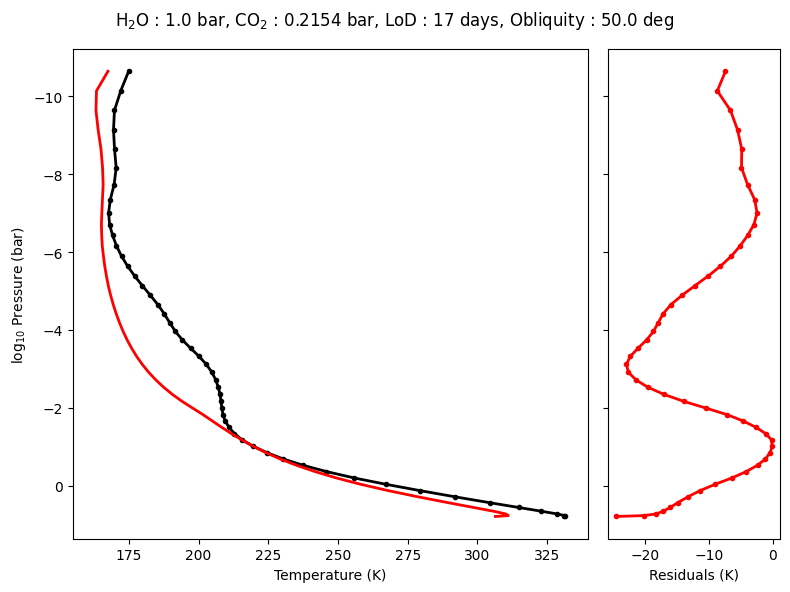

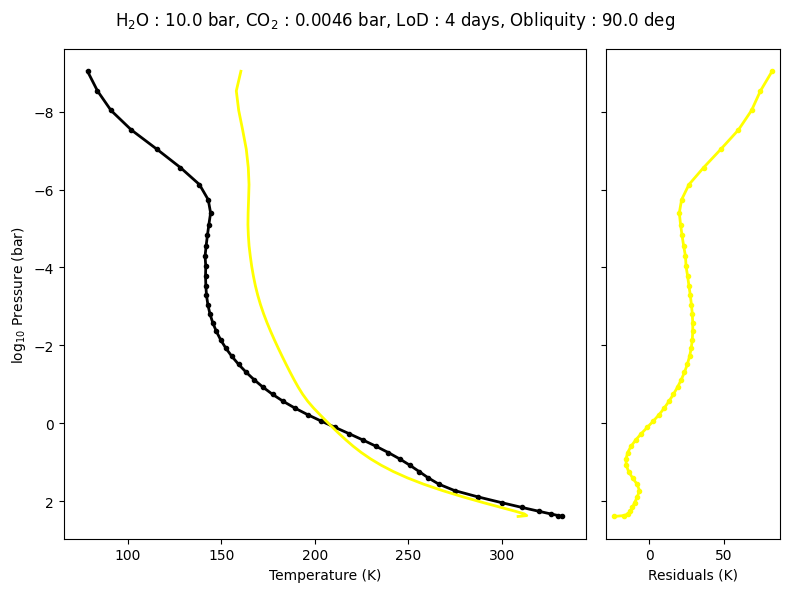

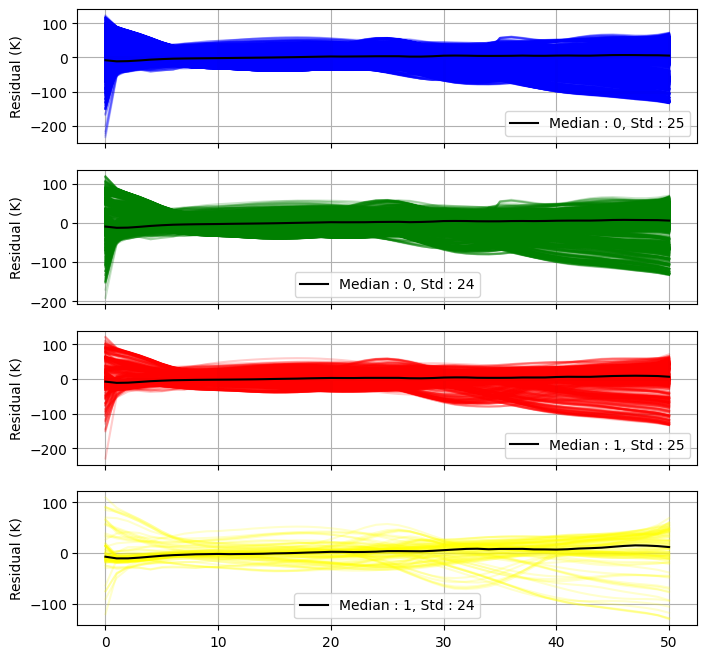

In [ ]:
#Defining partition of data used for 1. training and 2. testing
data_partitions = [[0.5, 0.5], [0.7, 0.3], [0.9, 0.1], [0.99, 0.01]]

#Defining the noise seed for the random partitioning of the training data
partition_seed = 4

# Setting noise seed
generator = torch.Generator().manual_seed(partition_seed)

for part_idx, (data_partition, partition_color) in enumerate(zip(data_partitions, ['blue', 'green', 'red', 'yellow'])):
    
    #Splitting the data 
    ## Retrieving indices of data partitions
    train_idx, test_idx = torch.utils.data.random_split(range(N), data_partition, generator=generator)
    ## Generate the data partitions
    ### Training
    train_inputs = raw_inputs[train_idx]
    train_outputs_T = raw_outputs_T[train_idx]
    ### Testing
    test_inputs = raw_inputs[test_idx]
    test_outputs_T = raw_outputs_T[test_idx]
    test_outputs_P = raw_outputs_P[test_idx]

    # Retrieve model features for all the testing data
    model_test_outputs_T, model_test_outputs_T_cov = ens_GP(train_inputs, train_outputs_T, test_inputs, 1e-9)

    # Retrieve errors on the model features
    model_test_outputs_T_err = np.sqrt(np.diag(model_test_outputs_T_cov))

    # Basic diagnostic plot

    #Comparing predicted T-P profiles vs true T-P profiles with residuals
    substep = 500

    for test_idx, (test_input, test_output_T, test_output_P, pred_output_T) in enumerate(zip(test_inputs, test_outputs_T, test_outputs_P, model_test_outputs_T)):

        #Plotting
        if (test_idx % substep == 0):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8, 6], sharey=True, gridspec_kw = {'width_ratios':[3, 1]})
            ax1.plot(test_output_T, np.log(test_output_P/1000), '.', linestyle='-', color='black', linewidth=2)
            ax1.plot(pred_output_T, np.log(test_output_P/1000), color=partition_color, linewidth=2)
            ax1.invert_yaxis()
            ax1.set_ylabel(r'log$_{10}$ Pressure (bar)')
            ax1.set_xlabel('Temperature (K)')
            ax2.plot(pred_output_T - test_output_T, np.log(test_output_P/1000), '.', linestyle='-', color=partition_color, linewidth=2)
            ax2.set_xlabel('Residuals (K)')
            plt.suptitle(rf'H$_2$O : {test_input[0]} bar, CO$_2$ : {test_input[1]} bar, LoD : {test_input[2]:.0f} days, Obliquity : {test_input[3]} deg')
            plt.tight_layout()
            plt.show()


fig1, axs_res_1 = plt.subplots(4, 1, sharex=True, figsize=[8, 8])

for part_idx, (data_partition, partition_color, ax_res_1) in enumerate(zip(data_partitions, ['blue', 'green', 'red', 'yellow'], axs_res_1.ravel())):
    
    #Splitting the data 
    ## Retrieving indices of data partitions
    train_idx, test_idx = torch.utils.data.random_split(range(N), data_partition, generator=generator)
    ## Generate the data partitions
    ### Training
    train_inputs = raw_inputs[train_idx]
    train_outputs_T = raw_outputs_T[train_idx]
    ### Testing
    test_inputs = raw_inputs[test_idx]
    test_outputs_T = raw_outputs_T[test_idx]
    test_outputs_P = raw_outputs_P[test_idx]

    # Retrieve model features for all the testing data
    model_test_outputs_T, model_test_outputs_T_cov = ens_GP(train_inputs, train_outputs_T, test_inputs, 1e-9)

    #Residual plot 

    #Calculate the residuals
    residuals = model_test_outputs_T - test_outputs_T

    #Plot the residuals
    for residual in residuals:
        ax_res_1.plot(residual, color=partition_color, alpha=0.2)
    ax_res_1.plot(np.median(residuals, axis=0), color='black', zorder=2, label=f'Median : {np.median(residuals):.0f}, Std : {np.std(residuals):.0f}')
    ax_res_1.grid()
    ax_res_1.legend()
    ax_res_1.set_ylabel('Residual (K)')
plt.show()


## Fourth step : Explore the impact of regularizer

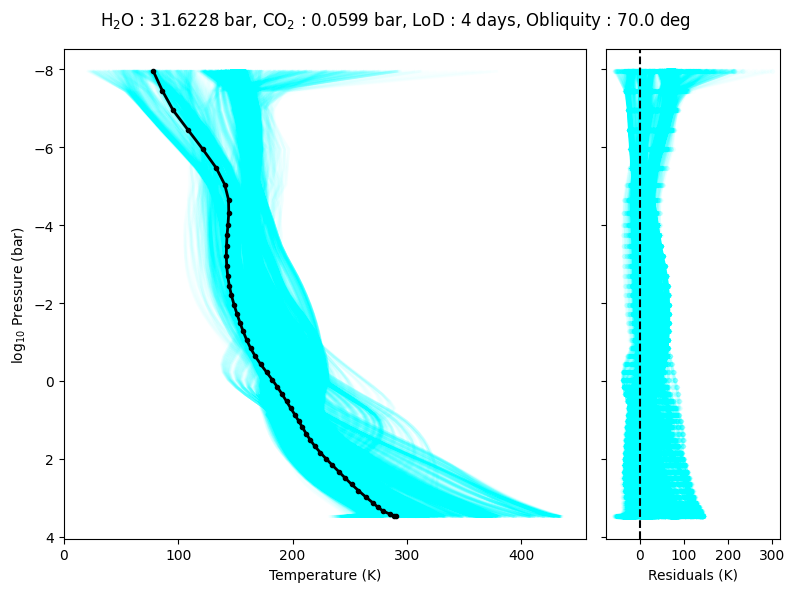

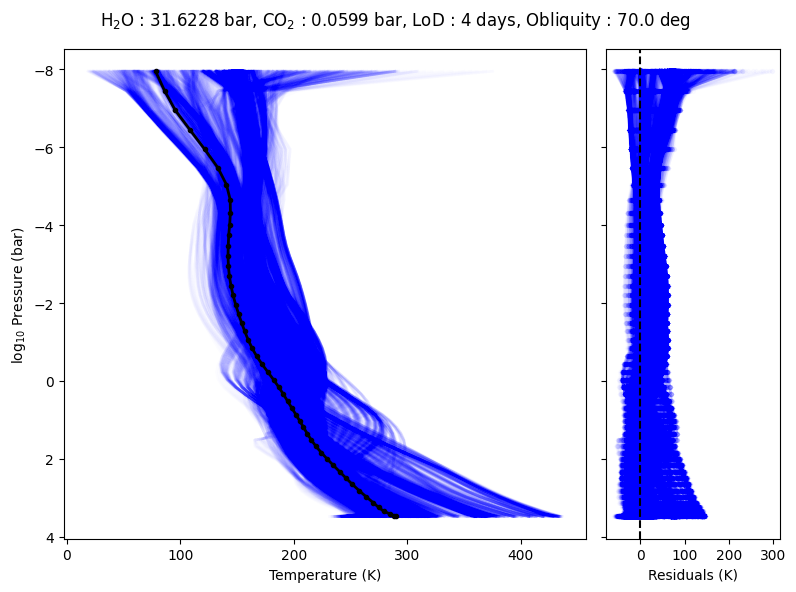

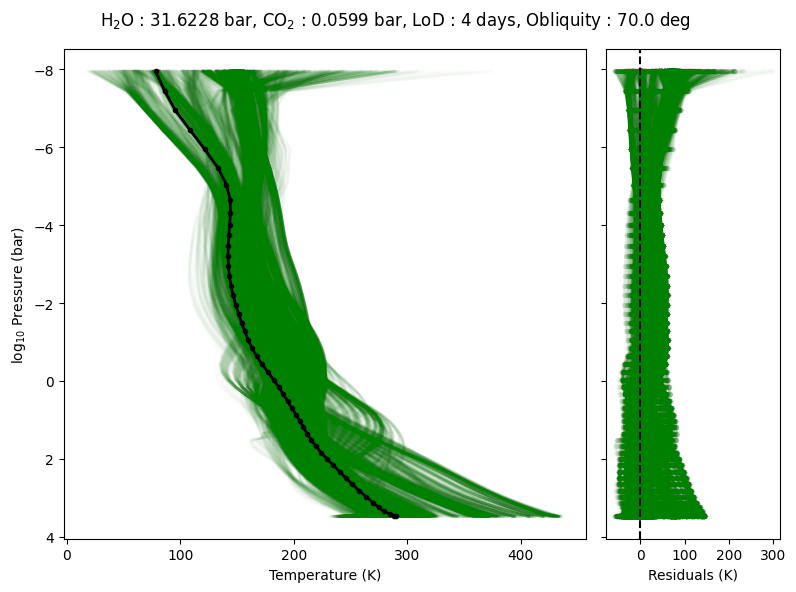

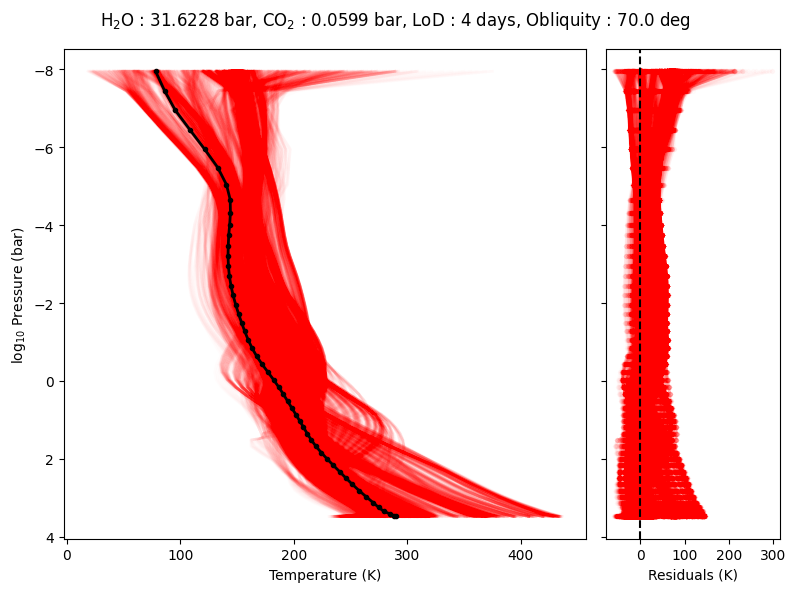

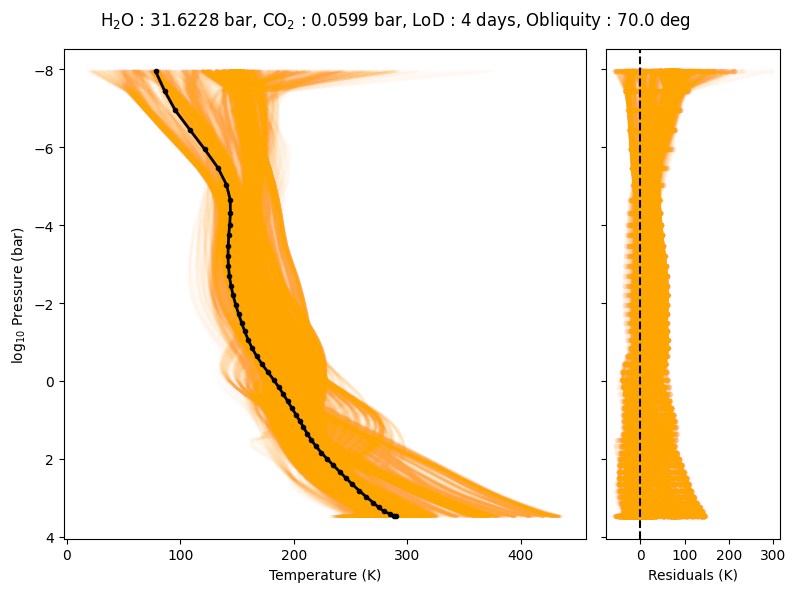

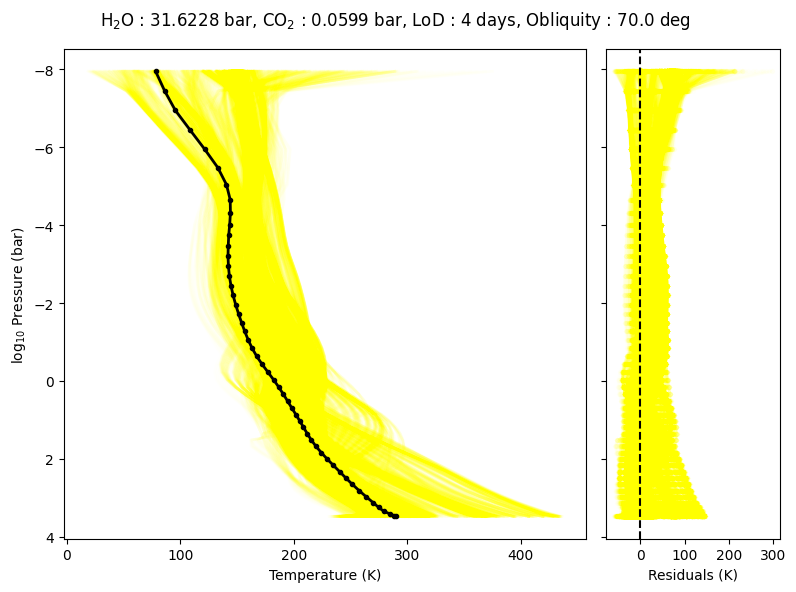

In [ ]:
#Defining partition of data used for 1. training and 2. testing
data_partitions = [0.9999, 0.0001]

#Defining the noise seed for the random partitioning of the training data
partition_seed = 4

# Setting noise seed
generator = torch.Generator().manual_seed(partition_seed)

#Splitting the data 
## Retrieving indices of data partitions
train_idx, test_idx = torch.utils.data.random_split(range(N), data_partition, generator=generator)
## Generate the data partitions
### Training
train_inputs = raw_inputs[train_idx]
train_outputs_T = raw_outputs_T[train_idx]
### Testing
test_inputs = raw_inputs[test_idx]
test_outputs_T = raw_outputs_T[test_idx]
test_outputs_P = raw_outputs_P[test_idx]

# Defining regularizers
lambda_regs = [100, 1, 1e-3, 1e-6, 1e-9, 1e-12]


for part_idx, (lambda_reg, partition_color) in enumerate(zip(lambda_regs, ['cyan', 'blue', 'green', 'red', 'orange', 'yellow'])):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8, 6], sharey=True, gridspec_kw = {'width_ratios':[3, 1]})

    # Retrieve model features for all the testing data
    model_test_outputs_T = ens_GP(train_inputs, train_outputs_T, test_inputs, lambda_reg)

    # Basic diagnostic plot

    #Plotting
    ax1.plot(test_outputs_T[0], np.log(test_outputs_P[0]/1000), '.', linestyle='-', color='black', linewidth=2, zorder=2)
    for pred_output_T in model_test_outputs_T:ax1.plot(pred_output_T, np.log(test_outputs_P[0]/1000), color=partition_color, linewidth=2, alpha=0.01, zorder=1)
    ax1.invert_yaxis()
    ax1.set_ylabel(r'log$_{10}$ Pressure (bar)')
    ax1.set_xlabel('Temperature (K)')
    for pred_output_T in model_test_outputs_T:ax2.plot(pred_output_T - test_outputs_T[0], np.log(test_outputs_P[0]/1000), '.', linestyle='-', color=partition_color, linewidth=2, alpha=0.01, zorder=1)
    ax2.axvline(0, color='black', linestyle='dashed', zorder=2)
    ax2.set_xlabel('Residuals (K)')
    plt.suptitle(rf'H$_2$O : {test_input[0]} bar, CO$_2$ : {test_input[1]} bar, LoD : {test_input[2]:.0f} days, Obliquity : {test_input[3]} deg')
    plt.tight_layout()
    plt.show()
